## Preliminares y funciones

In [1]:
import numpy as np
import seaborn, os
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats

In [2]:
%run ../medidas_biodiversidad.py

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
seaborn.set_palette("deep", color_codes=True)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.figsize'] = (7.5, 6)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [5]:
def leer_datos(het):
    files = os.listdir("../datos/exp1b")
    files.sort()
    files = list(filter(lambda x: x[7] == het, files))
    
    datos = [np.load("../datos/exp1b/" + file) for file in files]
    comunidad = [file[10:13] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    median = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[:, i])
        std[i] = np.std(riquezas[:, i])
        median[i] = np.median(riquezas[:, i])
    return promedios, std, median

In [7]:
def elegir_umbral(poblaciones, t=-1, i=9):
    ''' Calcula la abundancia de las n especies en un tiempo t y un nivel de intensificación i.
    Luego elige un umbral de supervivencia apropiado para esa comunidad...
    Recibe un arreglo con la forma poblaciones[intensificacion, tiempo, x, y, especie],
    que corresponde a los datos de una comunidad, en un nivel de heterogeneidad, esto es, 
    uno de los archivos que se guardaron del modelo.
    '''
    abundancia_especies = np.zeros(poblaciones.shape[-1])
    for especie in range(poblaciones.shape[-1]):
        abundancia_especies[especie] = np.sum(poblaciones[i,t,:,:,especie])
    
    umbral = 1.1 * np.min(abundancia_especies[abundancia_especies>10]) # observar este parámetro
    
    return umbral

## Leer datos, calcular riqueza

In [8]:
datos = np.zeros((5, 100, 10, 6, 10, 10, 10)) # het, comunidad, intensificación, tiempo, x, y, especies
for het in range(5):
    datos[het] = leer_datos(str(het))[0]

In [12]:
riqueza_total = np.zeros((5, 100, 10)) # het, comunidad, intensificación

for het in range(5):
    for comunidad in range(len(datos[het])):
        for intensificacion in range(len(datos[het, comunidad])):
            riqueza_total[het, comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[het, comunidad, intensificacion, ...],
                                                    t=-1, biomasa_min = 30)[1]

¿Cuántas comunidades no tuvieron cambios en el nivel de heterogeneidad intermedio (het=2)? Este es el criterio para distinguir si la dinámica de migración y población están acopladas. El resto del análisis se hace sólo con estas comunidades, que son 80.

In [13]:
# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
count = 0
con_cambios = []
for het in [2]:
    for c in range(100):
        if riqueza_total[het][c, 0] != riqueza_total[het][c, 9]:
            count += 1
            con_cambios.append(c)
100-count

21

In [14]:
np.save('./con_cambios', con_cambios)
con_cambios = np.load('con_cambios.npy')

In [15]:
riqueza_total_mean = np.zeros((5, 10)) # het, intensificación
riqueza_total_sd = np.zeros((5, 10))
riqueza_total_median = np.zeros((5, 10))

for het in range(5):
    riqueza_total_mean[het], riqueza_total_sd[het], riqueza_total_median[het] = calcular_promedio(riqueza_total[het, con_cambios, :])

## Graficar


In [16]:
def graficar(medida, promedios, sd):
    """Graficar promedios de una medida de biodiversidad con curva ajustada ponderada.
    """
    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5
    r2_adj = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']

    for het in range(4, -1, -1):
        res[het] = np.polyfit(xdata, promedios[het], 2)
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
        
        r2_adj[het] = r2[het] - (1 - r2[het]) * (2/(10-2-1))
        
    fig = plt.figure()

    for het in range(4, -1, -1):
        y[het] = p[het](x)
        label = '{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                 het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2_adj[het]))
        
        plt.plot(x, y[het], lw = 4, color= colors[het], label='{}'.format(label)) #fit
        plt.plot(xdata, promedios[het], 'o', color= colors[het]) #data points
        
    plt.ylim(-0.05, 7.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel('Mean richness')
    plt.title('Richness decline in 10%-habitat landscapes')
    plt.legend(loc='center left', title="heterogeneity", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [17]:
def graficar_histogramas(medida, ylim):
    '''Graficar histogramas en heterogeneidad 4, 1, 0; intensificación 0, 3, 6, 9.
    '''
    bins = 11
    hrange=(0, 11)
    fig = plt.figure(figsize=(11, 8))
    palette = ['Blues_r', 'Greens_r', 'Oranges_r']
    texture = ['x', '.', '-']
    gs = gridspec.GridSpec(3, 4)
    gs.update(wspace=0.04)
    gs.update(hspace=0.3)
    for i, het in enumerate([4, 1, 0]):
        colors = seaborn.color_palette(palette[i], 5)
        for j, intensification in enumerate([0, 3, 6, 9]):
            ax = plt.subplot(gs[i, j])
            plt.hist(np.array(medida)[het, :, intensification], bins, range=hrange, color=colors[j], 
                         label='{}, {}'.format(het, intensification), width=1, align='left');
            plt.ylim(0, ylim);
            plt.xlim(-0.5, 10.5)
            plt.setp(ax.get_xticklabels(), size=9)
            plt.setp(ax.get_yticklabels(), visible=(intensification==0), size=11)
            plt.setp(ax.get_xgridlines(), visible=False)
            plt.box()
    plt.savefig('figS2.png', dpi=300, bbox_inches='tight')

In [14]:
np.shape(riqueza_total)

(5, 100, 10)

## Resultados

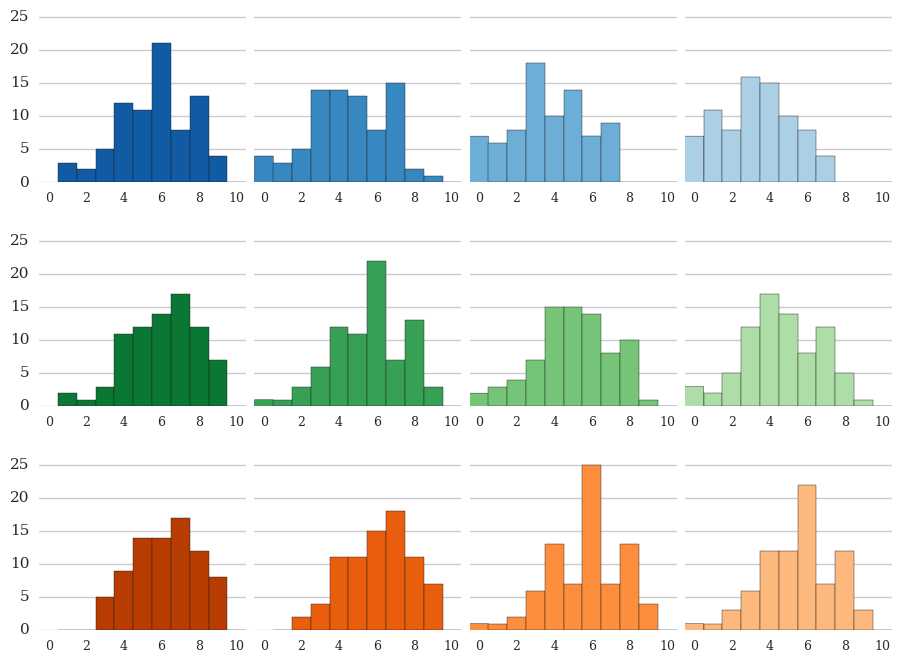

In [23]:
graficar_histogramas(riqueza_total[:, con_cambios, :], ylim=26)

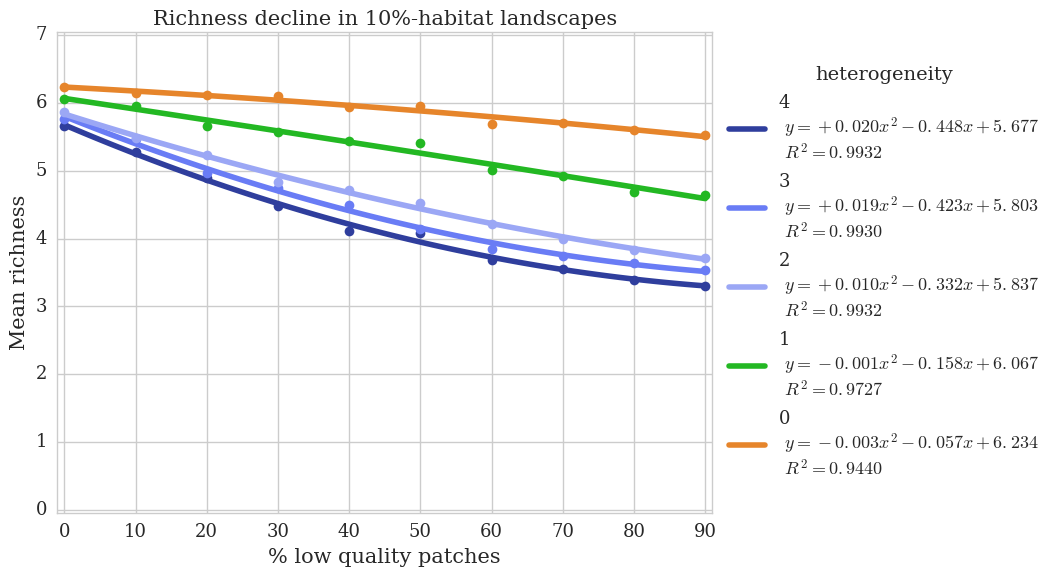

In [19]:
graficar('Species richness', riqueza_total_mean, riqueza_total_sd)

## Clasificar curvas

Clasificar las curvas de decaimiento de riqueza de cada comunidad, en cada nivel de heterogeneidad, ¿son cóncavas hacia arriba o hacia abajo?

In [ ]:
def clasificar(riquezas, grado):
    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))

    res = np.polyfit(xdata, riquezas, grado)
    p = np.poly1d(res)
    r2 = 1 - ((np.sum((p(range(10)) - riquezas)**2)) /
             (np.sum((riquezas - np.mean(riquezas))**2)))
    r2_adjusted = r2 - (1 - r2) * (degree/(10-degree-1))
    
    return res[0]

In [ ]:
curves = np.zeros((5, 100))
for het in range(5):
    for n, comunidad in enumerate(riqueza_total[het]):
        curves[het, n] = clasificar(comunidad, 2)

In [ ]:
summary_curves = np.zeros((5, 2))

In [ ]:
for het in range(5):
    summary_curves[het, 0] = len(curves[het, :][curves[het, :]<0])
    summary_curves[het, 1] = len(curves[het, :][curves[het, :]>0])

In [ ]:
summary_curves

## Identifying significant differences in richness

Note: shape of `biodiversity_measure` is `[heterogeneity, communities, intensification]`.

### Do data distribute normally?

We use Shapiro-Wilk test. Null hypothesis is that data subsets came from a normally distributed population.

**Result:** Data subsets don't follow a normal distribution. 

In [101]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = riqueza_total[het, con_cambios, i]
        
        pvalue = stats.shapiro(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.0014, ---NOT NORMAL---
H0, i1, p= 0.0019, ---NOT NORMAL---
H0, i2, p= 0.0021, ---NOT NORMAL---
H0, i3, p= 0.0008, ---NOT NORMAL---
H0, i4, p= 0.0037, ---NOT NORMAL---
H0, i5, p= 0.0037, ---NOT NORMAL---
H0, i6, p= 0.0087, ---NOT NORMAL---
H0, i7, p= 0.0097, ---NOT NORMAL---
H0, i8, p= 0.0094, ---NOT NORMAL---
H0, i9, p= 0.0022, ---NOT NORMAL---
H1, i0, p= 0.0012, ---NOT NORMAL---
H1, i1, p= 0.0042, ---NOT NORMAL---
H1, i2, p= 0.0091, ---NOT NORMAL---
H1, i3, p= 0.0070, ---NOT NORMAL---
H1, i4, p= 0.0028, ---NOT NORMAL---
H1, i5, p= 0.0024, ---NOT NORMAL---
H1, i6, p= 0.0035, ---NOT NORMAL---
H1, i7, p= 0.0081, ---NOT NORMAL---
H1, i8, p= 0.0023, ---NOT NORMAL---
H1, i9, p= 0.0023, ---NOT NORMAL---
H2, i0, p= 0.0024, ---NOT NORMAL---
H2, i1, p= 0.0026, ---NOT NORMAL---
H2, i2, p= 0.0025, ---NOT NORMAL---
H2, i3, p= 0.0065, ---NOT NORMAL---
H2, i4, p= 0.0042, ---NOT NORMAL---
H2, i5, p= 0.0064, ---NOT NORMAL---
H2, i6, p= 0.0004, ---NOT NORMAL---
H2, i7, p= 0.0001, ---NOT NO

However, using D'Agostino and Pearson's omnibus test, data subsets are normal. Again, null hypothesis is that data subsets came from a normally distributed population.

In [132]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = riqueza_total[het, con_cambios, i]
        
        pvalue = stats.normaltest(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.1076, normal
H0, i1, p= 0.0273, ---NOT NORMAL---
H0, i2, p= 0.0132, ---NOT NORMAL---
H0, i3, p= 0.0451, ---NOT NORMAL---
H0, i4, p= 0.3166, normal
H0, i5, p= 0.0613, normal
H0, i6, p= 0.2263, normal
H0, i7, p= 0.1254, normal
H0, i8, p= 0.4049, normal
H0, i9, p= 0.3390, normal
H1, i0, p= 0.0105, ---NOT NORMAL---
H1, i1, p= 0.0232, ---NOT NORMAL---
H1, i2, p= 0.4123, normal
H1, i3, p= 0.4631, normal
H1, i4, p= 0.3072, normal
H1, i5, p= 0.3072, normal
H1, i6, p= 0.2003, normal
H1, i7, p= 0.1589, normal
H1, i8, p= 0.2674, normal
H1, i9, p= 0.2838, normal
H2, i0, p= 0.0499, ---NOT NORMAL---
H2, i1, p= 0.2949, normal
H2, i2, p= 0.2447, normal
H2, i3, p= 0.2204, normal
H2, i4, p= 0.1458, normal
H2, i5, p= 0.2864, normal
H2, i6, p= 0.2811, normal
H2, i7, p= 0.2009, normal
H2, i8, p= 0.0669, normal
H2, i9, p= 0.0565, normal
H3, i0, p= 0.1357, normal
H3, i1, p= 0.2902, normal
H3, i2, p= 0.1775, normal
H3, i3, p= 0.2386, normal
H3, i4, p= 0.3302, normal
H3, i5, p= 0.2811, normal
H3, 

Do data have the same variance?

We use Levene test, which does not assume normality. Null hypothesis is that population variances are equal. In particular, we want to know whether data subsets from all heterogeneity levels have the same variance at each intensification level.

**Result:** At each intensification level, richness from all heterogeneity levels has equal variance.

In [103]:
# Richness
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(riqueza_total[0, con_cambios, i],
                          riqueza_total[1, con_cambios, i],
                          riqueza_total[2, con_cambios, i],
                          riqueza_total[3, con_cambios, i],
                          riqueza_total[4, con_cambios, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.9951, equal std
i1, pvalue=1.0000, equal std
i2, pvalue=0.9889, equal std
i3, pvalue=0.9549, equal std
i4, pvalue=0.8810, equal std
i5, pvalue=0.7710, equal std
i6, pvalue=0.2952, equal std
i7, pvalue=0.1620, equal std
i8, pvalue=0.1193, equal std
i9, pvalue=0.0533, equal std


We get the same results using Bartlett test.

In [104]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.bartlett(riqueza_total[0, con_cambios, i],
                          riqueza_total[1, con_cambios, i],
                          riqueza_total[2, con_cambios, i],
                          riqueza_total[3, con_cambios, i],
                          riqueza_total[4, con_cambios, i],)[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.9834, equal std
i1, pvalue=0.9926, equal std
i2, pvalue=0.9816, equal std
i3, pvalue=0.9930, equal std
i4, pvalue=0.9925, equal std
i5, pvalue=0.9716, equal std
i6, pvalue=0.5351, equal std
i7, pvalue=0.4230, equal std
i8, pvalue=0.2782, equal std
i9, pvalue=0.1171, equal std


*Extra:* Do data from each heterogeneity level have same variance across the intensification gradient?

**Result:** Only het 0, 1 and 2.

In [105]:
for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(riqueza_total[het, :, 0],
                      riqueza_total[het, con_cambios, 1],
                      riqueza_total[het, con_cambios, 2],
                      riqueza_total[het, con_cambios, 3],
                      riqueza_total[het, con_cambios, 4],
                      riqueza_total[het, con_cambios, 5],
                      riqueza_total[het, con_cambios, 6],
                      riqueza_total[het, con_cambios, 7],
                      riqueza_total[het, con_cambios, 8],
                      riqueza_total[het, con_cambios, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.4f}, {}'.format(het, pvalue, equal_std))

h0, pvalue=0.9990, equal std
h1, pvalue=0.9378, equal std
h2, pvalue=0.2505, equal std
h3, pvalue=0.0210, ---std NOT EQUAL---
h4, pvalue=0.0034, ---std NOT EQUAL---


### Differences between heterogeneity levels

We use Kruskal test to identify significant differences in biodiversity between heterogeneity levels at each level of intensification. Null hypothesis is that population medians are equal.

There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [106]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(riqueza_total[4, con_cambios, i],
                           riqueza_total[3, con_cambios, i],
                           riqueza_total[2, con_cambios, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.7325, no difference
i1, pvalue=0.7445, no difference
i2, pvalue=0.3265, no difference
i3, pvalue=0.6871, no difference
i4, pvalue=0.0561, no difference
i5, pvalue=0.0626, no difference
i6, pvalue=0.1726, no difference
i7, pvalue=0.2246, no difference
i8, pvalue=0.2132, no difference
i9, pvalue=0.1320, no difference


Given that data don't seem to differ significantly from normality, we can use ANOVA tests. In this case, null hyphotesis is that group means are equal. We get similar results: There is no significant difference between heterogeneity levels 4, 3 and 2, except at lowest intensification. 

In [107]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(riqueza_total[4, con_cambios, i],
                           riqueza_total[3, con_cambios, i],
                           riqueza_total[2, con_cambios, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.7419, no difference
i1, pvalue=0.7497, no difference
i2, pvalue=0.3131, no difference
i3, pvalue=0.6715, no difference
i4, pvalue=0.0689, no difference
i5, pvalue=0.0725, no difference
i6, pvalue=0.1568, no difference
i7, pvalue=0.2388, no difference
i8, pvalue=0.2212, no difference
i9, pvalue=0.1624, no difference


Heterogeneity levels 4 (highest) and 0 (lowest) are significantly different at all intensification levels.

In [108]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(riqueza_total[4, con_cambios, i],
                           riqueza_total[0, con_cambios, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0082, ---DIFFERENT---
i1, pvalue=0.0031, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


In [28]:
# Area - TO DO
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(area)[4, :, i],
                           np.array(area)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

NameError: name 'area' is not defined

We get the same results using ANOVA.

In [109]:
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(riqueza_total[4, con_cambios, i],
                            riqueza_total[0, con_cambios, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0069, ---DIFFERENT---
i1, pvalue=0.0020, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


At what intensification levels are heterogeneity levels 4, 1 and 0 different from each other? This is, at what intensification levels is het1 different from het4 and from het0?

In [110]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(riqueza_total[4, con_cambios, i],
                               riqueza_total[1, con_cambios, i])[1]
    
    pvalue_10 = stats.kruskal(riqueza_total[0, con_cambios, i],
                               riqueza_total[1, con_cambios, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14= {:.4f}, pvalue_10= {:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14= 0.0971, pvalue_10= 0.2898, -
i1, pvalue_14= 0.0433, pvalue_10= 0.3360, -
i2, pvalue_14= 0.0139, pvalue_10= 0.0686, -
i3, pvalue_14= 0.0010, pvalue_10= 0.0863, -
i4, pvalue_14= 0.0000, pvalue_10= 0.0830, -
i5, pvalue_14= 0.0000, pvalue_10= 0.0569, -
i6, pvalue_14= 0.0000, pvalue_10= 0.0156, ---DIFFERENT---
i7, pvalue_14= 0.0000, pvalue_10= 0.0078, ---DIFFERENT---
i8, pvalue_14= 0.0000, pvalue_10= 0.0012, ---DIFFERENT---
i9, pvalue_14= 0.0000, pvalue_10= 0.0029, ---DIFFERENT---


With ANOVA:

In [111]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.f_oneway(riqueza_total[4, con_cambios, i],
                               riqueza_total[1, con_cambios, i])[1]
    
    pvalue_10 = stats.f_oneway(riqueza_total[0, con_cambios, i],
                               riqueza_total[1, con_cambios, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.0898, pvalue_10=0.2976, -
i1, pvalue_14=0.0375, pvalue_10=0.3047, -
i2, pvalue_14=0.0114, pvalue_10=0.0581, -
i3, pvalue_14=0.0007, pvalue_10=0.0721, -
i4, pvalue_14=0.0000, pvalue_10=0.0810, -
i5, pvalue_14=0.0000, pvalue_10=0.0519, -
i6, pvalue_14=0.0000, pvalue_10=0.0137, ---DIFFERENT---
i7, pvalue_14=0.0000, pvalue_10=0.0064, ---DIFFERENT---
i8, pvalue_14=0.0000, pvalue_10=0.0009, ---DIFFERENT---
i9, pvalue_14=0.0000, pvalue_10=0.0024, ---DIFFERENT---


In [131]:
np.savetxt('means_10.txt', riqueza_total_mean, '%.4f', delimiter=',', newline='\r\n')